In this repository, we test how good the fixed point caluclation is and is the dynamical system remains stable for this arbitrary recurrent weight matrix.

In [21]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import math
from perturbed_organics.spectrum_general import matrix_solution
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
from perturbed_organics.utils.util_funs import dynm_fun
import numpy as np
import os
from matplotlib import colors
from scipy.optimize import fsolve, curve_fit
from scipy import integrate
import warnings


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
cmap = 'viridis'

In [58]:
"""Define the parameters of the ORGaNICs"""
N = 150
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.02,
    'noise_type': 'additive'
}
b0 = 0.5 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
sigma = 0.1
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [59]:
def sample_sparse_matrix(N, c, delta, mu):
    mask = torch.bernoulli(torch.full((N, N), c / N)).triu()
    values = torch.normal(mu, delta, (N, N))
    upper_triangular = values * mask
    symmetric_matrix = upper_triangular + upper_triangular.T - torch.diag(torch.diag(upper_triangular))
    return symmetric_matrix

In [66]:
"""Define the scan parameters"""
num_delta = 10
num_gamma = 10
delta_range = torch.linspace(0, 0.25, num_delta)
gamma_range = torch.linspace(0, 1, num_gamma)

mu = 0.0
#c = math.sqrt(N) # sparsity
c = 1


# define the quantities that we'll calculate
num_trials = 10
eigenvals_wyy = torch.zeros((num_delta, num_gamma, num_trials, N), dtype=torch.complex64)
eigenvals_J = torch.zeros((num_delta, num_gamma, num_trials, 2 * N), dtype=torch.complex64)

norm_fixed_point_y = torch.zeros((num_delta, num_gamma, num_trials, N))
norm_fixed_point_a = torch.zeros((num_delta, num_gamma, num_trials, N))

actual_fixed_point_y = torch.zeros((num_delta, num_gamma, num_trials, N))
actual_fixed_point_a = torch.zeros((num_delta, num_gamma, num_trials, N))

bool_stable = torch.zeros((num_delta, num_gamma, num_trials), dtype=torch.bool)

In [63]:
for i, delta in enumerate(delta_range):
    for j, gamma in enumerate(gamma_range):
        # define the norm of the input drive
        z = torch.ones(N)
        z = z / torch.norm(z) * gamma

        for k in range(num_trials):
            try :
                # sample a random Wyy matrix
                Wyy = torch.eye(N) + sample_sparse_matrix(N, c, delta, mu)
                eigenvals_wyy[i, j, k] = torch.linalg.eigvals(Wyy)

                # instantiate the model
                model = organics.ORGaNICs2Dgeneral(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=True)

                # normalization fixed point
                norm_fixed_point_y[i, j, k], norm_fixed_point_a[i, j, k] = model.analytical_ss()

                # actual fixed point
                actual_fixed_point_y[i, j, k] = model.ss[0:N] # will catch a None type object is not scriptable error here
                actual_fixed_point_a[i, j ,k] = model.ss[N:2*N]

                # eigenvalues of the jacobian
                eigenvals_J[i, j, k] = torch.linalg.eigvals(model.J)

                bool_stable[i, j, k] = True

            except Exception as e:
                bool_stable[i, j, k] = False

In [64]:
# import Flaviano's data
data_sim = np.loadtxt('../data/balanced_exp_N10_n100.txt')
data_a = np.loadtxt('../data/function_contours.txt')
data_y = np.loadtxt('../data/y_contours.txt')

/tmp/ipykernel_1638700/1410012581.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=20, loc='lower right')


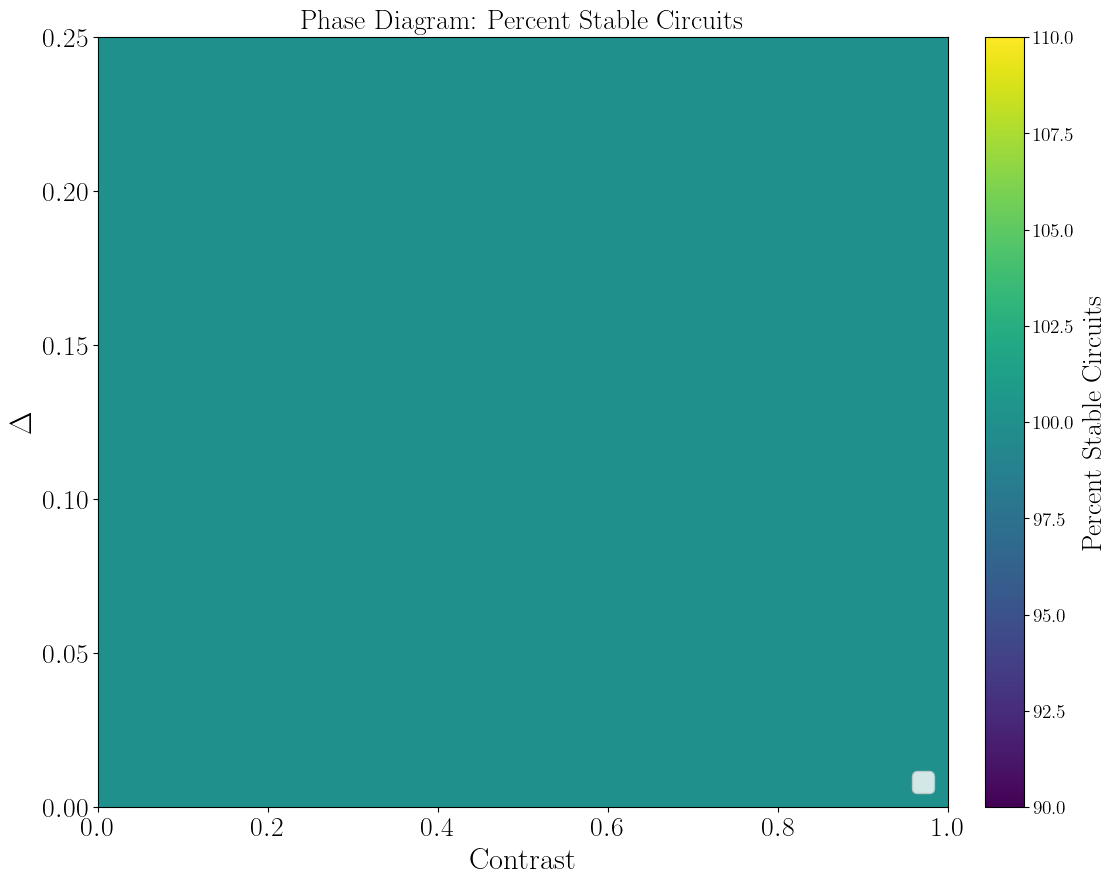

In [65]:
# Calculate the percentage of stable circuits
percent_stable = bool_stable.float().mean(dim=2) * 100

# Plot the heatmap
plt.figure(figsize=(12, 10))
plt.imshow(percent_stable, extent=[gamma_range.min(), gamma_range.max(), delta_range.min(), delta_range.max()],
           origin='lower', aspect='auto', cmap='viridis')
colorbar = plt.colorbar(label="Percent Stable Circuits", fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=14)

# plotting curve from flaviano
# plt.scatter(data_sim[:, 1], data_sim[:, 0], c='black', edgecolor='black', s=50, label="Simulation")
# plt.scatter(data_y[:, 0], data_y[:, 1], c='cyan', edgecolor='black', s=50, label="y-theory")
# plt.scatter(data_a[:, 0], data_a[:, 1], c='red', edgecolor='black', s=50, label="a-theory")

# add legend
plt.legend(fontsize=20, loc='lower right')


# Set font sizes
plt.xlabel(r'Contrast', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22)
plt.title("Phase Diagram: Percent Stable Circuits", fontsize=20)

# Increase tick label size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
colorbar.set_label("Percent Stable Circuits", fontsize=20)
# save the figure in svg
plt.savefig('../figures/percent_stable_circuits.svg')
plt.show()

In [57]:
# create a folder in ..data/ to save the results
folder_name = 'sparse_matrix_scan_N_{}_c_{}_mu_{}_num_delta_{}_num_gamma_{}_num_trials_{}'.format(N, c, mu, num_delta, num_gamma, num_trials)
path = os.path.join('..', 'data', folder_name)
# make th edirectory
if not os.path.exists(path):
    os.makedirs(path)
# save all the tensors in the folder
torch.save(eigenvals_wyy, os.path.join(path, 'eigenvals_wyy.pt'))
torch.save(eigenvals_J, os.path.join(path, 'eigenvals_J.pt'))
torch.save(norm_fixed_point_y, os.path.join(path, 'norm_fixed_point_y.pt'))
torch.save(norm_fixed_point_a, os.path.join(path, 'norm_fixed_point_a.pt'))
torch.save(actual_fixed_point_y, os.path.join(path, 'actual_fixed_point_y.pt'))
torch.save(actual_fixed_point_a, os.path.join(path, 'actual_fixed_point_a.pt'))
torch.save(bool_stable, os.path.join(path, 'bool_stable.pt'))